In [4]:
!wget https://archive.ics.uci.edu/static/public/275/bike+sharing+dataset.zip

--2024-08-27 05:34:00--  https://archive.ics.uci.edu/static/public/275/bike+sharing+dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘bike+sharing+dataset.zip’

bike+sharing+datase     [ <=>                ] 273.43K  1.37MB/s    in 0.2s    

2024-08-27 05:34:01 (1.37 MB/s) - ‘bike+sharing+dataset.zip’ saved [279992]



In [5]:
!unzip bike+sharing+dataset.zip

Archive:  bike+sharing+dataset.zip
  inflating: Readme.txt              
  inflating: day.csv                 
  inflating: hour.csv                


In [56]:
import pandas as pd

In [57]:
df = pd.read_csv('hour.csv')

In [58]:
df['day_night'] = df['hr'].apply(lambda x: 'day' if 6 <= x <= 18 else 'night')

In [59]:
df.drop(['instant', 'casual', 'registered'], axis=1, inplace=True)
df['dteday'] = pd.to_datetime(df.dteday)
df['season'] = df.season.astype('category')
df['holiday'] = df.holiday.astype('category')
df['weekday'] = df.weekday.astype('category')
df['weathersit'] = df.weathersit.astype('category')
df['workingday'] = df.workingday.astype('category')
df['mnth'] = df.mnth.astype('category')
df['yr'] = df.yr.astype('category')
df['hr'] = df.hr.astype('category')
df.drop(columns=['dteday'], inplace=True)

# Separating features and target variable
X = df.drop(columns=['cnt']) # Features
y = df['cnt'] # Target

#One Hot Encoder --

In [55]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
# Numerical features
numerical_features = ['temp', 'hum', 'windspeed']
numerical_pipeline = Pipeline([
('imputer', SimpleImputer(strategy='mean')), # Impute missing values with mean
('scaler', MinMaxScaler()) # Normalize using MinMaxScaler
])
# Transforming above
X[numerical_features] = numerical_pipeline.fit_transform(X[numerical_features])
# Categorical features
categorical_features = ['season', 'weathersit', 'day_night']
categorical_pipeline = Pipeline([
('imputer', SimpleImputer(strategy='most_frequent')),
('onehot', OneHotEncoder(sparse_output=False, drop='first'))
])
# Transforming above
X_encoded = categorical_pipeline.fit_transform(X[categorical_features])
# Converting it to a dataframe

X_encoded = pd.DataFrame(X_encoded,
columns = categorical_pipeline.named_steps['onehot'].get_feature_names_out(categorical_features))
# Encoded categorical features + Numerical features
X = pd.concat([X.drop(columns=categorical_features), X_encoded], axis=1)

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
random_state=42)

In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

<Axes: >

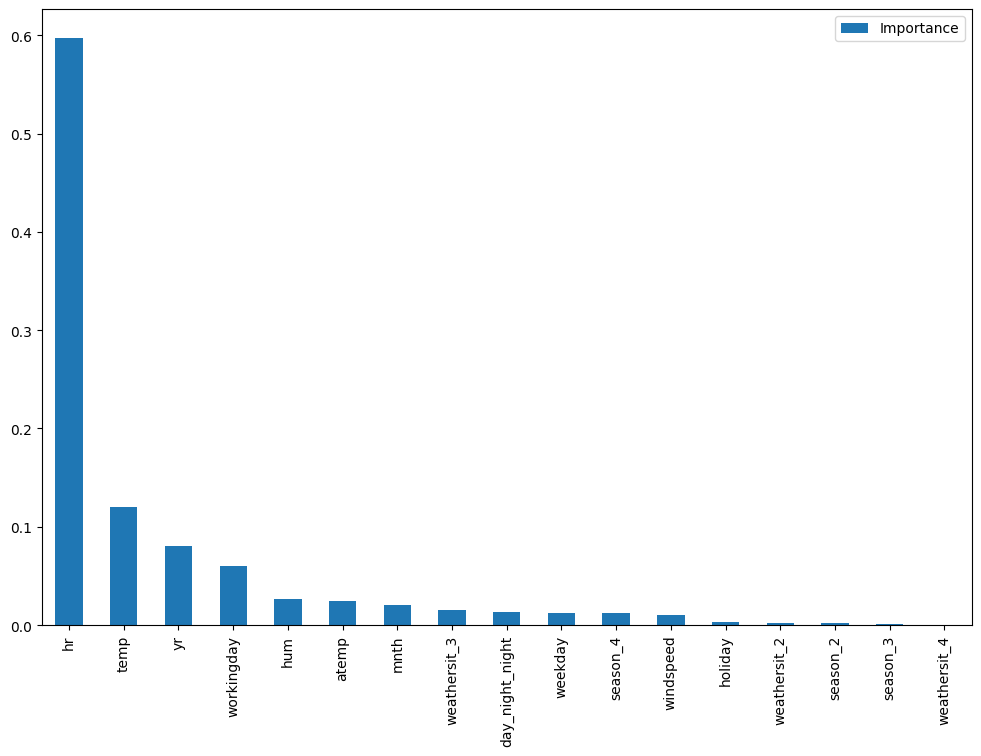

In [14]:
feat_importances = pd.DataFrame(model.feature_importances_, index=X_train.columns,
columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
# Plotting each feature importance
feat_importances.plot(kind='bar', figsize=(12,8))

In [15]:
# Predictions
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 1808.4074990292243
R-squared: 0.9428901308176855


In [16]:
from sklearn import set_config

final_pipeline = Pipeline([
('num_preprocess', numerical_pipeline),
('cat_preprocess', categorical_pipeline),
('model', RandomForestRegressor(n_estimators=100, random_state=42))
])
set_config(display='diagram')# To display
final_pipeline

Pipeline(steps=[('num_preprocess',
                 Pipeline(steps=[('imputer', SimpleImputer()),
                                 ('scaler', MinMaxScaler())])),
                ('cat_preprocess',
                 Pipeline(steps=[('imputer',
                                  SimpleImputer(strategy='most_frequent')),
                                 ('onehot',
                                  OneHotEncoder(drop='first',
                                                sparse_output=False))])),
                ('model', RandomForestRegressor(random_state=42))])

Creating 2 new interaction features-

In [27]:
df['temp_hum'] = df['temp'] * df['hum']
df['temp_windspeed'] = df['temp'] * df['windspeed']

In [ ]:
!pip3 install target_encoding

In [ ]:
!pip3 install category_encoders

#Target Encoder --

In [62]:
import pandas as pd
from category_encoders import TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import set_config

# Load and preprocess the data
df = pd.read_csv('hour.csv')

df['day_night'] = df['hr'].apply(lambda x: 'day' if 6 <= x <= 18 else 'night')

df.drop(['instant', 'casual', 'registered'], axis=1, inplace=True)
df['dteday'] = pd.to_datetime(df.dteday)
df.drop(columns=['dteday'], inplace=True)

# Convert specific columns to categorical
categorical_cols = ['season', 'holiday', 'weekday', 'weathersit', 'workingday', 'mnth', 'yr', 'hr']
df[categorical_cols] = df[categorical_cols].astype('category')

# Separate features and target variable
X = df.drop(columns=['cnt'])
y = df['cnt']

In [63]:
# Numerical features
numerical_features = ['temp', 'hum', 'windspeed']
numerical_pipeline = Pipeline([
('imputer', SimpleImputer(strategy='mean')), # Impute missing values with mean
('scaler', MinMaxScaler()) # Normalize using MinMaxScaler
])
# Transforming above
X[numerical_features] = numerical_pipeline.fit_transform(X[numerical_features])

In [64]:
# Apply target encoding to the categorical features in df
categorical_features = ['season', 'weathersit', 'day_night']
target_encoder = TargetEncoder()

df_encoded = target_encoder.fit_transform(df[categorical_features], y)

# Replace the original categorical columns in df with the encoded ones
df = pd.concat([df.drop(columns=categorical_features), df_encoded], axis=1)

# Separating features and target variable again, since df has changed
X = df.drop(columns=['cnt'])  # Features
y = df['cnt']  # Target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

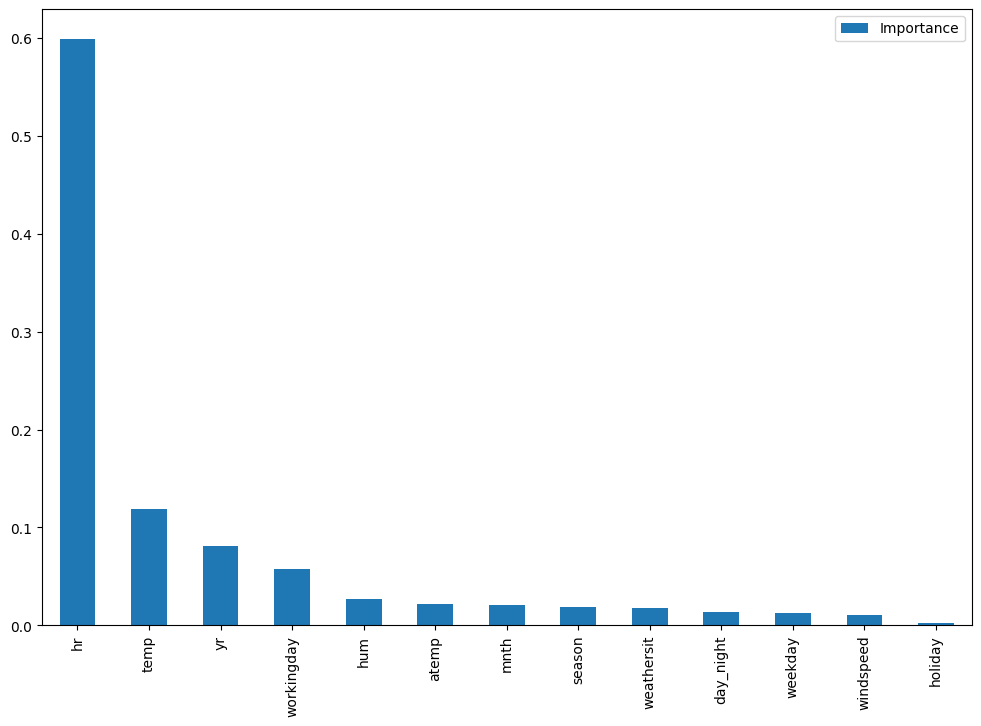

In [65]:
# Train the RandomForestRegressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Feature importances
feat_importances = pd.DataFrame(model.feature_importances_, index=X_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)

# Plotting each feature importance
feat_importances.plot(kind='bar', figsize=(12, 8))

# Predictions
y_pred = model.predict(X_test)

In [70]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('target_encoder', TargetEncoder())
])

final_pipeline = Pipeline([
    ('num_preprocess', numerical_pipeline),
    ('cat_preprocess', categorical_pipeline),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])
"""# Display the final pipeline configuration without the categorical preprocessing step
final_pipeline = Pipeline([
    ('num_preprocess', numerical_pipeline),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])"""

set_config(display='diagram')  # To display the pipeline
final_pipeline

Mean Squared Error: 1733.5103015778614
R-squared: 0.9452553992380307


Pipeline(steps=[('num_preprocess',
                 Pipeline(steps=[('imputer', SimpleImputer()),
                                 ('scaler', MinMaxScaler())])),
                ('cat_preprocess',
                 Pipeline(steps=[('imputer',
                                  SimpleImputer(strategy='most_frequent')),
                                 ('target_encoder', TargetEncoder())])),
                ('model', RandomForestRegressor(random_state=42))])

In [68]:
df['temp_hum'] = df['temp'] * df['hum']
df['temp_windspeed'] = df['temp'] * df['windspeed']

In [69]:
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)

mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)
print(f'Linear Regression - Mean Squared Error: {mse_linear}')
print(f'Linear Regression - R-squared: {r2_linear}')

Linear Regression - Mean Squared Error: 15112.954426556415
Linear Regression - R-squared: 0.5227298876374706
